## Description:
这里是DSIN的一个demo， 主要分为数据读取与处理，模型搭建，模型的训练三大模块

In [1]:
# python基础包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 特征处理与数据集划分
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from utils import DenseFeat, SparseFeat, VarLenSparseFeat

# 导入模型
from DSIN import DSIN

# 模型训练相关
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

# 一些相关设置
import warnings
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

## 导入数据

In [2]:
"""读取数据"""
samples_data = pd.read_csv("data/movie_sample.txt", sep="\t", header = None)
samples_data.columns = ["user_id", "gender", "age", "hist_movie_id", "hist_len", "movie_id", "movie_type_id", "label"]

#  把历史行为序列转成整数列表
def str2list(x):
    return [int(i) for i in x.split(',')]
samples_data['hist_movie_id'] = samples_data['hist_movie_id'].apply(lambda x: str2list(x))

In [3]:
"""会话处理"""
# 把hist_movie_id拆成6个会话， 每个会话的长度是10， 会话不够的0填充
for i in range(5):
    samples_data['sess' + str(i+1)] = samples_data['hist_movie_id'].apply(lambda x: x[i*10:(i+1)*10])

# 每个样本的会话个数  这里的hist_len其实就是sess_nums了，这里这么写是想练一波python处理
sess_nums = np.array([len([int(i) for i in l if int(i) != 0]) // 10 + 1 for l in samples_data['hist_movie_id']])
sess_nums = np.array([i if i <= 5 else 5 for i in sess_nums])   # 这个是正好50个行为的这种，按照上面那个算会是6，但其实5个会话
sess_max_count = 5

del samples_data['hist_movie_id']

In [4]:
samples_data.head(2).append(samples_data.tail(2))

,user_id,gender,age,hist_len,movie_id,movie_type_id,label,sess1,sess2,sess3,sess4,sess5
0,1,1,1,1,112,2,1,"[186, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1,1,1,1,38,5,0,"[186, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1378,3,2,3,50,141,9,0,"[5, 207, 198, 147, 109, 82, 80, 57, 84, 200]","[88, 174, 193, 95, 183, 64, 162, 37, 28, 156]","[56, 135, 152, 38, 41, 130, 108, 23, 81, 105]","[137, 71, 86, 69, 68, 185, 169, 67, 11, 31]","[93, 92, 202, 83, 97, 126, 128, 197, 168, 32]"
1379,3,2,3,50,15,3,0,"[5, 207, 198, 147, 109, 82, 80, 57, 84, 200]","[88, 174, 193, 95, 183, 64, 162, 37, 28, 156]","[56, 135, 152, 38, 41, 130, 108, 23, 81, 105]","[137, 71, 86, 69, 68, 185, 169, 67, 11, 31]","[93, 92, 202, 83, 97, 126, 128, 197, 168, 32]"


In [5]:
"""数据集"""
X = samples_data.drop(columns='label')
y = samples_data["label"]

# 构建mask 是个列表，每个元素代表每个session里面序列的mask
mask = []
for i in range(sess_max_count):
    mask.append(
        np.array([len([k for k in l if k != 0]) for l in X['sess'+str(i+1)]])
    )

In [6]:
"""构建DSIN模型的输入格式"""
X_train = {"user_id": np.array(X["user_id"]), \
        "gender": np.array(X["gender"]), \
        "age": np.array(X["age"]), \
        "movie_id": np.array(X["movie_id"]), \
        "movie_type_id": np.array(X["movie_type_id"]), \
        "hist_len": np.array(X["hist_len"]), \
        "sess1": np.stack(X['sess1']), \
        "sess2": np.stack(X['sess2']), \
        "sess3": np.stack(X['sess3']), \
        "sess4": np.stack(X['sess4']), \
        "sess5": np.stack(X['sess5']), \
        "seq_length1": mask[0], \
        "seq_length2": mask[1], \
        "seq_length3": mask[2], \
        "seq_length4": mask[3], \
        "seq_length5": mask[4], \
        "sess_length": sess_nums
        }

y_train = np.array(y)

## 模型建立

In [7]:
"""特征封装"""

feature_columns = [SparseFeat('user_id', max(samples_data["user_id"])+1, embedding_dim=8), 
                    SparseFeat('gender', max(samples_data["gender"])+1, embedding_dim=8), 
                    SparseFeat('age', max(samples_data["age"])+1, embedding_dim=8), 
                    SparseFeat('movie_id', max(samples_data["movie_id"])+1, embedding_dim=8),
                    SparseFeat('movie_type_id', max(samples_data["movie_type_id"])+1, embedding_dim=8),
                    DenseFeat('hist_len', 1)]

feature_columns += [VarLenSparseFeat('sess1', vocabulary_size=max(samples_data["movie_id"])+1, embedding_dim=8, maxlen=10, length_name='seq_length1'),
                    VarLenSparseFeat('sess2', vocabulary_size=max(samples_data["movie_id"])+1, embedding_dim=8, maxlen=10, length_name='seq_length2'), 
                    VarLenSparseFeat('sess3', vocabulary_size=max(samples_data["movie_id"])+1, embedding_dim=8, maxlen=10, length_name='seq_length3'), 
                    VarLenSparseFeat('sess4', vocabulary_size=max(samples_data["movie_id"])+1, embedding_dim=8, maxlen=10, length_name='seq_length4'), 
                    VarLenSparseFeat('sess5', vocabulary_size=max(samples_data["movie_id"])+1, embedding_dim=8, maxlen=10, length_name='seq_length5'), 
                   ]
feature_columns += ['sess_length']

# 行为特征列表，表示的是基础特征
sess_feature_list = ['movie_id']

In [8]:
"""设置超参数"""
learning_rate = 0.001
batch_size = 64
epochs = 50

In [9]:
"""构建DSIN模型"""
model = DSIN(feature_columns, sess_feature_list, bias_encoding=True)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie_id (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
sess1 (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
sess2 (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
sess3 (InputLayer)              [(None, 10)]         0                                            
_____________________________________________________________________________________________

In [10]:
"""模型编译"""
model.compile(loss=binary_crossentropy, optimizer=Adam(learning_rate=learning_rate), metrics=[AUC()])

## 模型训练

In [11]:
"""模型训练"""
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),   # 早停
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.01, verbose=1)  # 调整学习率
]
history = model.fit(X_train, 
                    y_train, 
                    epochs=epochs, 
                    validation_split=0.2, 
                    batch_size=batch_size,
                    callbacks = callbacks
                   )

Train on 1104 samples, validate on 276 samples
Epoch 1/50
1104/1104 [==============================] - 3s 3ms/sample - loss: 0.5793 - auc: 0.5298 - val_loss: 0.5012 - val_auc: 0.4966
Epoch 2/50
1104/1104 [==============================] - 0s 243us/sample - loss: 0.4816 - auc: 0.5657 - val_loss: 0.4991 - val_auc: 0.4875
Epoch 3/50
1104/1104 [==============================] - 0s 254us/sample - loss: 0.4747 - auc: 0.5062 - val_loss: 0.4872 - val_auc: 0.4826
Epoch 4/50
1104/1104 [==============================] - 0s 257us/sample - loss: 0.4707 - auc: 0.5387 - val_loss: 0.5390 - val_auc: 0.4289
Epoch 5/50
1104/1104 [==============================] - 0s 255us/sample - loss: 0.4776 - auc: 0.5074 - val_loss: 0.4829 - val_auc: 0.4310
Epoch 6/50
1104/1104 [==============================] - 0s 259us/sample - loss: 0.4904 - auc: 0.5152 - val_loss: 0.5025 - val_auc: 0.4239
Epoch 7/50
1104/1104 [==============================] - 0s 225us/sample - loss: 0.4929 - auc: 0.5451 - val_loss: 0.5532 - val_a

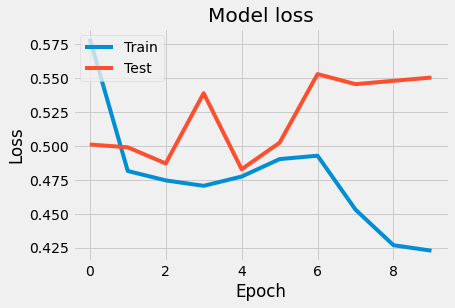

In [12]:
"""可视化下看看训练情况"""
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 模型架构可视化

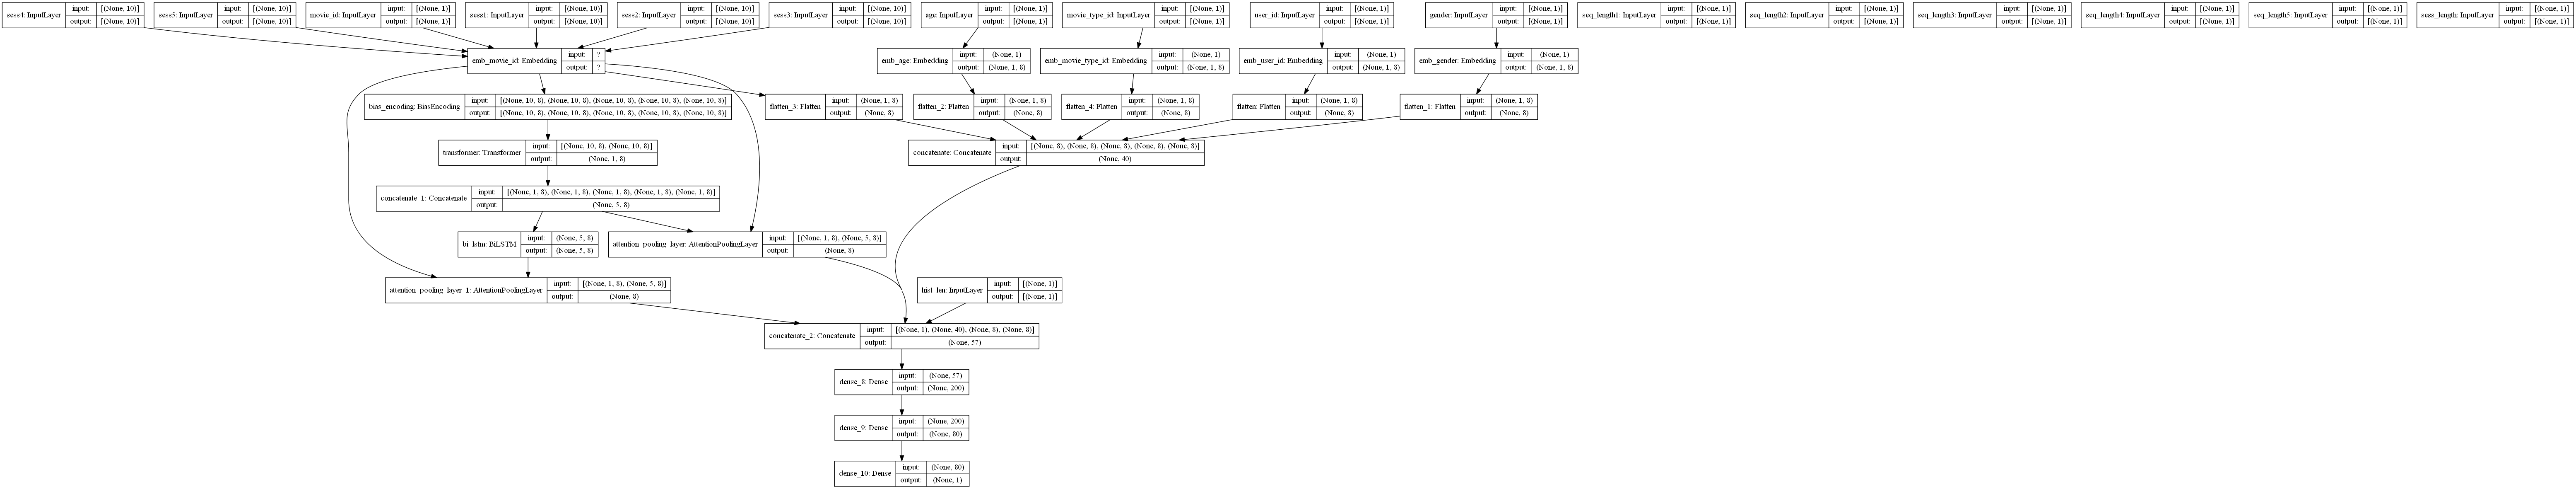

In [13]:
from tensorflow import keras
keras.utils.plot_model(model, to_file='./DSIN.png', show_shapes=True)